In [12]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
mpl.rcParams['figure.dpi'] = 180
sns.set_style('darkgrid')
pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.functional as F
from torch import optim

from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, display_side
from src.data_processing import encode_batch, onehot_batch_decode, get_mia
from src.data_processing import encode_batch_weighted, onehot_batch_decode, onehot_decode, INT_TO_CHAR
from src.data_processing import compute_frequency, batch_compute_frequency
from src.models import CNN_1, FFN_1, NetParent
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Reloading CEDAR (concat + scored)
new_dataset = pd.read_csv('../data/cedar_neoepitope_220701_scored.csv')
concat_dataset = pd.read_csv('../data/cedar_concat_scored.csv')
# Reloading ICs
ics_shannon = pkl_load('../output/ics_shannon.pkl')
ics_kl = pkl_load('../output/ics_kl.pkl')
# Randomly adding human proteome
hp=pd.read_csv('../output_xls/subsampled/humanprot_sub_N50_seed13_scored.txt').rename(columns={'EL_Rank':'trueHLA_EL_rank',
                                                                'BA_Rank':'BA_rank'})
hp[['percentage_pos', 'agg_label', 'label', 'total_count']] = 0, 0, 'Negative', 1

In [15]:
train,test = train_test_split(new_dataset, test_size=0.15, random_state=13, stratify=new_dataset['agg_label'])

x_train, x_test = batch_compute_frequency(encode_batch_weighted(train, ics_shannon)), batch_compute_frequency(encode_batch_weighted(test, ics_shannon))
y_train, y_test = torch.from_numpy(train['agg_label'].values), torch.from_numpy(test['agg_label'].values)
x_train.shape, y_train.shape

(torch.Size([2958, 20]), torch.Size([2958]))

# sampling tests

In [ ]:
km = []
len_weights = {8: 0.05718390804597701,
               9: 0.475,
               10: 0.2775862068965517,
               11: 0.1896551724137931,
               12: 0.0005747126436781609}
for k in [8,9,10,11,12]:
    val= len_weights[k]
    tmp = pd.concat([pd.read_csv(f'../output_xls/filtered_rank20/HLA-A0201_{k}mers_humanproteome_chunk_{c}.xls_rank20.txt', sep='\t', skiprows=1)\
                     for c in [0,1,2,3]])
    tmp['wt'] = 1/tmp['EL_Rank']
    tmp['len']=k
    km.append(tmp.sample(int(val*len(tmp)), weights='wt'))
km = pd.concat(km)

KeyboardInterrupt: 

In [ ]:
km.sample(75, weights='wt', random_state=100).groupby('len').count()

In [ ]:
import math
f,a = plt.subplots(1,1, figsize=(5,3))

new_dataset.trueHLA_EL_rank.plot(kind='kde', ax = a, label = 'neoepi')
hp.trueHLA_EL_rank.plot(kind='kde', ax=a, label = 'sampled_HP')
hp['sample_weight1'] = 1/(10*np.abs((1-hp['trueHLA_EL_rank'])**3))
hp['sample_weight2'] = 1/hp['trueHLA_EL_rank']**3

# hp.sample(n=1500, weights='sample_weight1')['trueHLA_EL_rank'].plot(kind='kde', ax = a, label='1 weighted_sampling')
hp.sample(n=1500, weights='sample_weight2')['trueHLA_EL_rank'].plot(kind='kde', ax = a, label='2 weighted_sampling')
km.sample(50, weights='wt').EL_Rank.plot(kind='kde', ax=a, label='full hp weighted')
a.legend()
a.set_title('HLA rank dist')

# loading various datasets (old MISC)

In [ ]:
f,a = plt.subplots(figsize=(6,4))
palette = sns.color_palette('hsv', n_colors=13)
palette = [palette[8], palette[-1]]
sns.set_palette(palette)
pd.read_csv('../data/cedar_netmhc_scored.csv').groupby('agg_label')['EL_rank'].plot(kind='kde')
a.legend()

In [ ]:
import pandas as pd;
len(pd.read_excel('../data/raw_exports/neo_JUN2022_full_res.xlsx', sheet = '

In [ ]:
dataset_prime = pd.read_csv('../data/nn_data/PRIME_dataset.csv')
dataset_neoepi_hp = pd.read_csv('../data/nn_data/neoepi_hp_hobohm_scored.csv')
dataset_cedar_hp = pd.read_csv('../data/nn_data/cedar_hp_hohobm_scored.csv')
    
len(dataset_prime), len(dataset_neoepi_hp), len(dataset_cedar_hp)

In [ ]:
len(not_done)

In [ ]:
not_done = set(dataset_cedar_hp.query('dataset!="hp"')['HLA'].unique()).union(set(dataset_neoepi_hp.query('dataset!="hp"')['HLA']))
done = set(f"{x.split('_')[0][:7]}:{x.split('_')[0][7:]}" for x in os.listdir('../output_xls/') if 'HLA' in x)
not_done = sorted(set(x for x in not_done if x not in done))
' '.join(not_done)

In [ ]:
# Doesn't work??
display_side(dataset_prime.groupby('len')[['Peptide']].count(), 
             dataset_neoepi_hp.groupby('len')[['Peptide']].count(), 
             dataset_cedar_hp.groupby('len')[['Peptide']].count(),
            titles = ['Prime', 'neoepi', 'cedar_old'])

In [ ]:
display(dataset_prime.groupby('HLA')[['Peptide']].count().sort_values('Peptide',ascending=False))
display(dataset_neoepi_hp.groupby('HLA')[['Peptide']].count().sort_values('Peptide',ascending=False))
display(dataset_cedar_hp.groupby('HLA')[['Peptide']].count().sort_values('Peptide',ascending=False))

In [ ]:
ics = pkl_load('../output/ic_results_dict.pkl')
ics.keys(), ics[8].keys(), ics[8]['HLA-A0101'].keys()

In [ ]:
ics[9]['HLA-A0201']['0.1']

In [ ]:
get_mia(ics[9]['HLA-A0201']['0.5'], 0.3)

# Exploration / classic ML

## init

In [8]:
new_dataset.groupby('agg_label').count()

,Peptide,HLA,PMIDs,responses,label,total_count,percentage_pos,len,trueHLA_EL_rank,pred_HLA,core,icore,pred_EL_score,pred_EL_rank,BA_score,BA_rank
agg_label,,,,,,,,,,,,,,,,
0,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827,2827
1,653,653,653,653,653,653,653,653,653,653,653,653,653,653,653,653


In [16]:
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.linear_model import LogisticRegression as LOGREG
import xgboost as XGB
from sklearn.metrics import roc_auc_score, roc_curve

palette=sns.color_palette('hsv', n_colors = 13)
n4=[palette[x] for x in [0, 3, 8, -1]]
n3=[palette[x] for x in [-5, -3, -1]]
n2=[palette[-5], palette[-1]]
pals = {2:n2,
        3:n3,
        4:n4}

In [17]:
sns.color_palette(n4)

[(1.0, 0.4169121816180639, 0.0),
 (0.309189485660074, 1.0, 0.0),
 (0.0, 0.201472695957991, 1.0),
 (1.0, 0.0, 0.5106621816180639)]

## initial test

[14:04:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Text(0.5, 1.0, 'Using three models, new datadump & shannon IC weights')

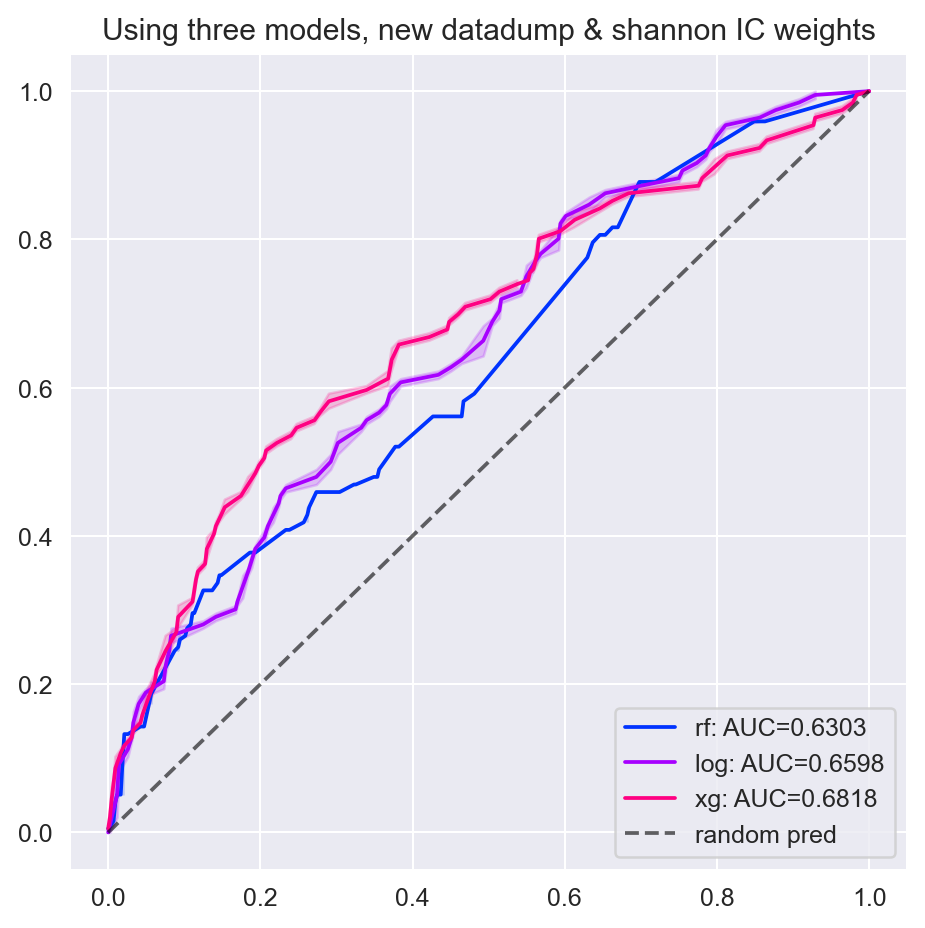

In [18]:
rf = RFC(n_estimators=100, max_depth=5, ccp_alpha=5e-3, random_state=13)
log = LOGREG(max_iter=500, random_state=13, C=0.1, tol = 1e-6)
xg = XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13)
models = {'rf': rf,
          'log': log,
          'xg': xg}
results = {}
sns.set_palette(pals[len(models)])
f,a = plt.subplots(1,1,figsize=(6,6))

for name, model in models.items():
    model.fit(x_train, y_train)
    scores = model.predict_proba(x_test)[:,1]
    auc = roc_auc_score(y_test, scores)
    fpr, tpr, _ = roc_curve(y_test, scores)
    results[name] = (auc, fpr, tpr)
    #a.set_title(f'ROC curves using {name} as model')
    sns.lineplot(x=fpr, y=tpr, label = f'{name}: AUC={auc.round(4)}', ax = a , n_boot=500, palette=n4)
    
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a )
a.legend(loc='lower right')#bbox_to_anchor=(.5,-.1))
a.set_title('Using three models, new datadump & shannon IC weights')

## weighted vs not

[14:04:15] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:17] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


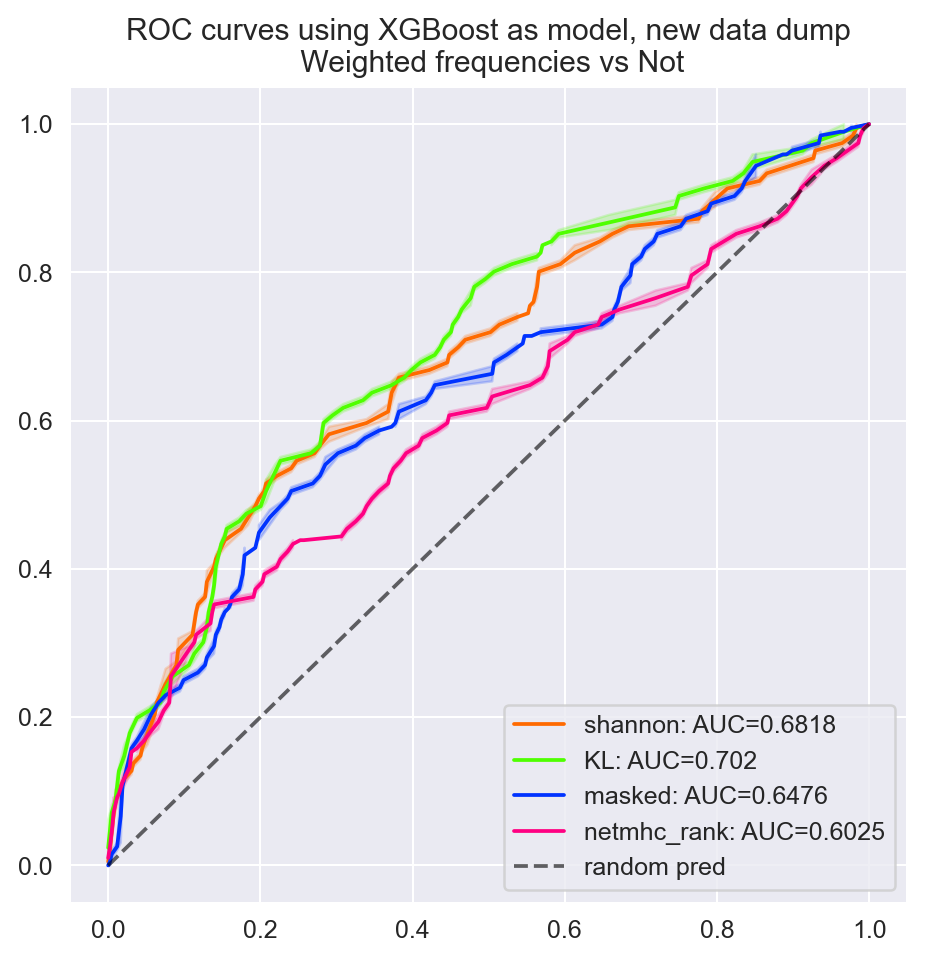

In [19]:
mods_w = {'shannon':XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13),
          'KL':XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13),
          'masked':XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13),
          'netmhc_rank':None}
sns.set_palette(pals[len(mods_w)])
res_w = {}

f,a = plt.subplots(1,1,figsize=(6,6))
for name,model in mods_w.items():
    if name != 'netmhc_rank':
        if name=='shannon':
            x_train, x_test = batch_compute_frequency(encode_batch_weighted(train, ics_shannon)), batch_compute_frequency(encode_batch_weighted(test, ics_shannon))
        if name=='KL':
            x_train, x_test = batch_compute_frequency(encode_batch_weighted(train, ics_kl)), batch_compute_frequency(encode_batch_weighted(test, ics_kl))
        elif name=='masked':
            x_train, x_test = batch_compute_frequency(encode_batch(train.Peptide.values)[:,4:,:]), batch_compute_frequency(encode_batch(test.Peptide.values)[:,4:,:])
        model.fit(x_train, y_train)
        scores = model.predict_proba(x_test)[:,1]
    elif name=='netmhc_rank':
        scores = -1*test.trueHLA_EL_rank.values
    auc = roc_auc_score(y_test, scores)
    fpr, tpr, _ = roc_curve(y_test, scores)
    res_w[name] = (auc, fpr, tpr)
    a.set_title(f'ROC curves using XGBoost as model, new data dump\n Weighted frequencies vs Not')
    sns.lineplot(x=fpr, y=tpr, label = f'{name}: AUC={auc.round(4)}', ax = a , n_boot=500, palette=n4)
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a )
a.legend(loc='lower right')#bbox_to_anchor=(.5,-.1))

## Adding Human Proteome to new datadump (+102 pep per HLA, 6.6k total)

In [20]:
hp['sample_weight'] = 1/(hp.trueHLA_EL_rank**3)
concatenated = pd.concat([new_dataset,hp.sample(frac=0.5, weights='sample_weight', random_state=13)])
cedar_hpnegs = pd.concat([new_dataset.query('agg_label==1'), hp.sample(frac=0.5, weights='sample_weight', random_state=13)])

696
cedar_only 696
[14:04:18] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
cedar_only_plus_rank 696
[14:04:19] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
concat 1034
[14:04:20] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
concat_plus_rank 1034
[14:04:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error

Text(0.5, 1.0, 'ROC curves using XGBoost as model, new data dump vs adding Human Proteome\n KL-Weighted frequencies')

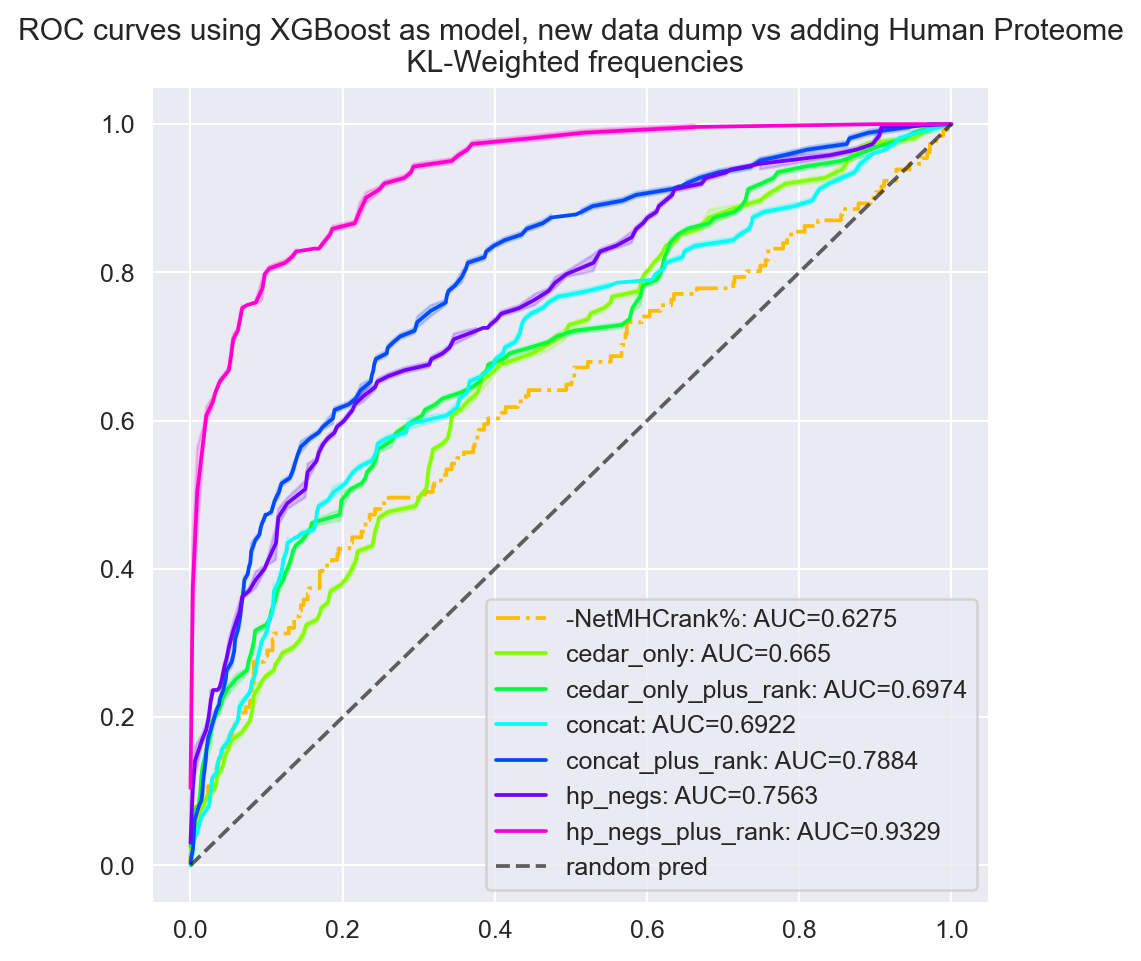

In [21]:
models_dict = {'cedar_only':{'model':XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13),
                             'dataset':new_dataset},
               'cedar_only_plus_rank':{'model':XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13),
                                             'dataset':new_dataset},
               'concat':{'model':XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13),
                         'dataset':concatenated},
               'concat_plus_rank':{'model':XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13),
                         'dataset':concatenated},
               'hp_negs':{'model':XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13),
                          'dataset':cedar_hpnegs},
              'hp_negs_plus_rank':{'model':XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13),
                          'dataset':cedar_hpnegs}}

sns.set_palette('hsv', n_colors=7)
res_w = {}

f,a = plt.subplots(1,1,figsize=(6,6))
for key, val in models_dict.items():
    train, test = train_test_split(val['dataset'], test_size=0.2, stratify=val['dataset']['agg_label'], random_state=13)
    x_train  = batch_compute_frequency(encode_batch_weighted(train, ics_kl))
    x_test = batch_compute_frequency(encode_batch_weighted(test, ics_kl))
    y_train, y_test = train['agg_label'].values, test['agg_label'].values
    # Query subset to remove HP from the test set to compare same performance
    # test = test.query('Peptide in @new_dataset.Peptide.values') 
    if key =='cedar_only':
        ranks = test.trueHLA_EL_rank.values * -1
        auc1 = roc_auc_score(y_test, ranks)
        fpr1, tpr1, _ = roc_curve(y_test, ranks)
        print(len(ranks))
        sns.lineplot(x=fpr1, y=tpr1, label = f'-NetMHCrank%: AUC={auc1.round(4)}', ax=a, estimator=None, ls='-.')
        
    if 'rank' in key:
        x_train = torch.concat([x_train, torch.from_numpy(train.trueHLA_EL_rank.values).unsqueeze(1)], dim=1)
        x_test = torch.concat([x_test, torch.from_numpy(test.trueHLA_EL_rank.values).unsqueeze(1)], dim=1)
        
    print(key, len(y_test))
    # Fit XGB & eval
    val['model'].fit(x_train, y_train)
    scores = val['model'].predict_proba(x_test)[:,1]
    # get ROC
    auc = roc_auc_score(y_test, scores)
    fpr, tpr, _ = roc_curve(y_test, scores)
    sns.lineplot(x=fpr, y=tpr, label = f'{key}: AUC={auc.round(4)}', ax = a , n_boot=500)
    # If using cedar, also get roc auc using netmhcpan-rank as score
    
    

sns.lineplot
sns.lineplot([0,1],[0,1], ls='--', color = 'k', label='random pred', alpha=0.6, ax=a )
a.legend(loc='lower right')#bbox_to_anchor=(.5,-.1))
a.set_title(f'ROC curves using XGBoost as model, new data dump vs adding Human Proteome\n KL-Weighted frequencies')

## Adding HP for training, but only keeping cedar for evaluation

In [31]:
# For prime
test['Peptide'].to_csv('../../../gfeller_tools/PRIME/data/cedar_neoepi_testset.pep', index=False, header=False)
','.join(sorted(test.HLA.str.replace('HLA-','').str.replace(':','').unique()))

'A0101,A0201,A0202,A0203,A0205,A0206,A0210,A0301,A0302,A1101,A1102,A2402,A2501,A2601,A2902,A3001,A3002,A3101,A3301,A6801,A6802,B0702,B0801,B1302,B1501,B1801,B2705,B3501,B3701,B3801,B3901,B4001,B4002,B4102,B4402,B4403,B5201,B5401,B5601,B5701,C0102,C0303,C0304,C0401,C0501,C0602,C0702,C0802,C1203,C1403'

[14:32:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:32:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:32:26] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:32:27] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

Text(0.5, 1.0, 'XGB trained with or without EL rank as feature\nUsing CEDAR or CEDAR+hp negs, evaluated on CEDAR')

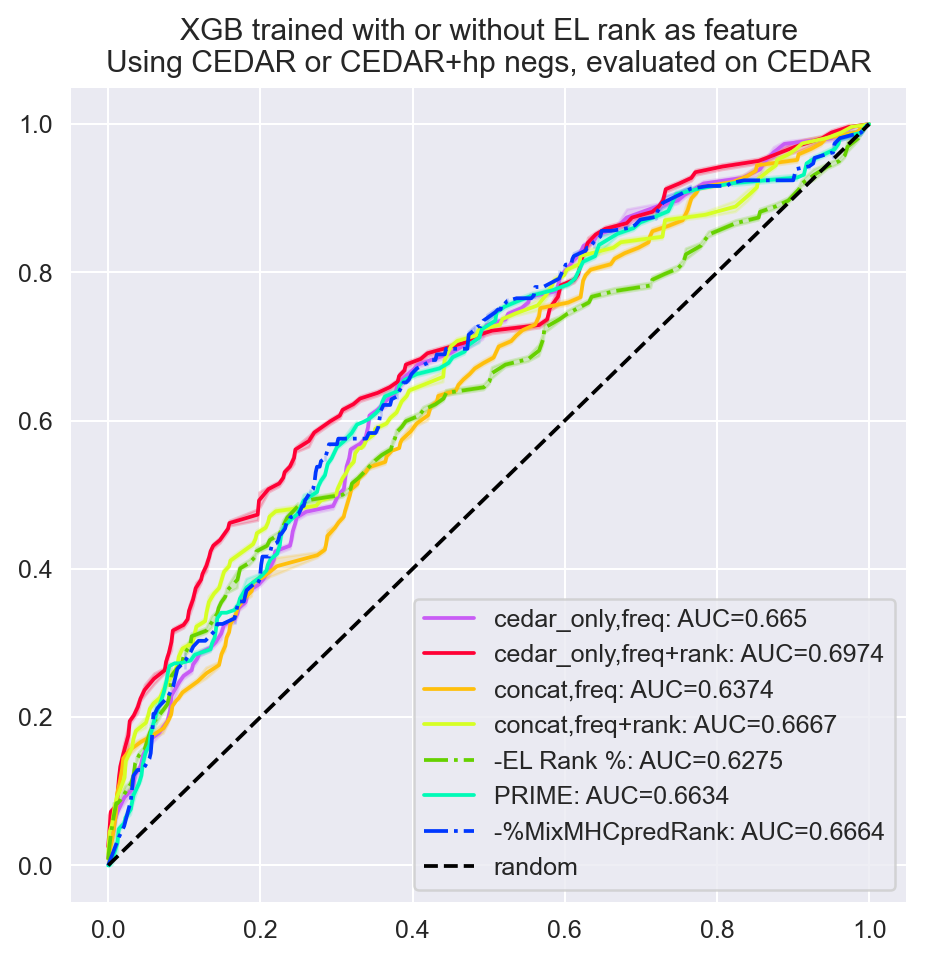

In [45]:
import sklearn
models_dict = {'cedar_only':{'model':XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13),
                             'dataset':new_dataset},
               'concat':{'model':XGB.XGBClassifier(n_estimators = 100, max_depth=5, learning_rate=1e-1,random_state=13),
                         'dataset':concatenated}}

sns.set_palette('gist_ncar_r', n_colors=7)
f,a = plt.subplots(1,1, figsize=(6,6))

_, test = train_test_split(new_dataset, test_size=0.2, random_state=13, stratify=new_dataset['agg_label'])
test_peps = test.Peptide.values
for k,v in models_dict.items():
    train, test = train_test_split(v['dataset'], test_size=0.2, random_state=13, stratify=v['dataset']['agg_label'])
    # Evaluate on subset only
    if k=='concat':
        train = v['dataset'].query('Peptide not in @test_peps')
        test = v['dataset'].query('Peptide in @test_peps')
    x_train, x_test = batch_compute_frequency(encode_batch_weighted(train, ics_kl)), batch_compute_frequency(encode_batch_weighted(test, ics_kl))
    y_train, y_test = train['agg_label'].values, test['agg_label'].values
    for features in ['freq', 'freq+rank']:
        if features == 'freq+rank':
            x_train = torch.concat([x_train, torch.from_numpy(train.trueHLA_EL_rank.values).unsqueeze(1)], dim=1)
            x_test = torch.concat([x_test, torch.from_numpy(test.trueHLA_EL_rank.values).unsqueeze(1)], dim=1)
        model = sklearn.base.clone(v['model'])
        model.fit(x_train, y_train)
        # get the scores for positive class
        scores = model.predict_proba(x_test)[:,1]
        auc = roc_auc_score(y_test, scores)
        fpr, tpr, _ = roc_curve(y_test, scores)
        sns.lineplot(x=fpr, y=tpr, n_boot=500, label = f'{k},{features}: AUC={auc.round(4)}', ax=a)

# adding rank as score
_, test = train_test_split(new_dataset, test_size=0.2, random_state=13, stratify=new_dataset['agg_label'])
auc_r = roc_auc_score(test['agg_label'].values, -1*test['trueHLA_EL_rank'].values)
fpr_r, tpr_r, _ = roc_curve(test['agg_label'].values, -1*test['trueHLA_EL_rank'].values)
sns.lineplot(x=fpr_r, y=tpr_r, ls = '-.', label = f'-EL Rank %: AUC={auc_r.round(4)}', n_boot=500)

# Adding prime results
prime_test = pd.read_csv('../../../gfeller_tools/PRIME/output/cedar_neoepi_testset.txt', comment='#', sep='\t')
prime_test = pd.merge(prime_test, test, left_on='Peptide', right_on='Peptide')
scores_prime = prime_test.Score_bestAllele.values
ranks_prime = prime_test['%Rank_bestAllele'].values * -1
y_true_prime = prime_test['agg_label'].values
# Prime score
auc_r = roc_auc_score(y_true_prime, scores_prime)
fpr_r, tpr_r, _ = roc_curve(y_true_prime, scores_prime)
sns.lineplot(x=fpr_r, y=tpr_r, label = f'PRIME: AUC={auc_r.round(4)}', n_boot=500)
# MixMHCpred score
auc_r = roc_auc_score(y_true_prime, ranks_prime)
fpr_r, tpr_r, _ = roc_curve(y_true_prime, ranks_prime)
sns.lineplot(x=fpr_r, y=tpr_r, ls = '-.', label = f'-%MixMHCpredRank: AUC={auc_r.round(4)}', n_boot=500)
# Adding random
sns.lineplot(x=[0,1], y=[0,1], color='k', ls='--', label = 'random')
a.legend()
a.set_title('XGB trained with or without EL rank as feature\nUsing CEDAR or CEDAR+hp negs, evaluated on CEDAR')


In [37]:
prime_test.columns

Index(['Peptide', '%Rank_bestAllele', 'Score_bestAllele',
       '%RankBinding_bestAllele', 'BestAllele', '%Rank_A0101', 'Score_A0101',
       '%RankBinding_A0101', '%Rank_A0201', 'Score_A0201',
       ...
       '%RankBinding_C0702', '%Rank_C0802', 'Score_C0802',
       '%RankBinding_C0802', '%Rank_C1203', 'Score_C1203',
       '%RankBinding_C1203', '%Rank_C1403', 'Score_C1403',
       '%RankBinding_C1403'],
      dtype='object', length=155)

## NN exploration